# Model hiper optimization

In [1]:
#imports
import os
from copy import copy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hypopt import GridSearch
from hyperopt import tpe, fmin, space_eval, Trials, STATUS_OK, hp
from sklearn.model_selection import StratifiedShuffleSplit

import pickle

In [63]:
# configs.
%matplotlib inline
# version to read
read_version = "1.2.b - group zone"

# model to save
model_id = "3.2.0.b -  total_condiciones_split_gte_4 with ZONE GROUPS without comp_cond and time_cond"

pd.set_option("display.max_columns", 500)

path = "../../../data/split"
random_state = 42
print(os.listdir(path))

['1.1.b - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train only 2018 without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.1 - df_train with nan.feather', '1.2.b - group zone - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1 - df_train.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to04-19.feather', '1.1 - df_val 01-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train without nulls.feather', '1.1 - df_train only 2018 without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train without nulls.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train only 2018 without nulls.fea

## Loading training and validation datasets

In [3]:
df = pd.read_feather(os.path.join(path, f"{read_version} - 01-17 to 01-19 - df_train with nan.feather"))
df_val = pd.read_feather(os.path.join(path, f"{read_version} - 01-17 to 01-19 - df_val 02-19to03-19.feather"))

In [4]:
# using only last year
# split_date = "2018-01-01"
# df = df[df["FECHA_SINI"] >= split_date].copy()

In [5]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [6]:
pd.crosstab(df["total_condicion"], df["EXISTE_FRAUDE"])

EXISTE_FRAUDE,False,True
total_condicion,,
0.0,983521,1705
1.0,44395,162
2.0,9329,216
3.0,42457,478
4.0,3258,35
5.0,2940,718
6.0,1314,94
7.0,219,99
8.0,203,80


In [7]:
# Select all non 060 tipo exped.
# 'None': 7,  '003': 2,  '060': 6,  '010': 3,  '020': 4,  '002': 1,  '050': 5,  '001': 0
df = df[(df["total_condicion"] >= 4)]
df_val = df_val[(df_val["total_condicion"] >= 4)]

In [8]:
pd.crosstab(df["total_condicion"], df["EXISTE_FRAUDE"])

EXISTE_FRAUDE,False,True
total_condicion,,
4.0,3258,35
5.0,2940,718
6.0,1314,94
7.0,219,99
8.0,203,80
9.0,28,4
10.0,61,44
11.0,6,2
12.0,9,8


In [9]:
df["TIPO_EXPED"].value_counts()

6    2634
5    2056
1    1849
7    1281
3     590
2     564
0     147
4      18
Name: TIPO_EXPED, dtype: int64

In [10]:
# delete unique value columns (for tipo_exped == 060)
use_cols = df.nunique()[df.nunique() > 1].index
df = df[use_cols]
df_val = df_val[use_cols]

In [11]:
cond_cols = df.filter(regex="^cond_*").columns
cond_cols

Index(['cond_04', 'cond_05', 'cond_06', 'cond_09', 'cond_11', 'cond_12',
       'cond_32', 'cond_37', 'cond_C1', 'cond_C10', 'cond_C11', 'cond_C12',
       'cond_C13', 'cond_C14', 'cond_C15', 'cond_C16', 'cond_C17', 'cond_C18',
       'cond_C19', 'cond_C2', 'cond_C20', 'cond_C21', 'cond_C3', 'cond_C4',
       'cond_C5', 'cond_C6', 'cond_C7', 'cond_C8', 'cond_C9'],
      dtype='object')

In [12]:
# create column number of conditions activated
df["cant_cond"] = (df[cond_cols] > 0).sum(axis=1)
df_val["cant_cond"] = (df_val[cond_cols] > 0).sum(axis=1)

In [13]:
df["cant_cond"].value_counts()

2    7012
1    1476
3     617
4      33
5       1
Name: cant_cond, dtype: int64

In [14]:
df["EXISTE_FRAUDE"].value_counts()

False    8048
True     1091
Name: EXISTE_FRAUDE, dtype: int64

In [15]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [16]:
df_val["FECHA_SINI"].min(), df_val["FECHA_SINI"].max()

(Timestamp('2019-02-01 00:00:00'), Timestamp('2019-03-31 00:00:00'))

In [17]:
pd.crosstab(df["FECHA_SINI"].dt.month, [df["EXISTE_FRAUDE"], df["TIPO_EXPED"]], margins=True)

EXISTE_FRAUDE False                                 True                All
TIPO_EXPED        0     1    2    3   4     5     6    1  3   5     6      
FECHA_SINI                                                                 
1.0              23   199   73   51   1   211   367    1  0  11   206  1143
2.0              16   131   20    3   0    98    64    0  0   5    34   371
3.0              10   117   31    1   0   101    57    0  0   1    40   358
4.0              13   139   31    0   2   106    48    0  0   8    31   378
5.0               9   127   32    3   1   119    94    1  0   7    47   440
6.0              16   147   32    0   0   128   119    0  0  10    52   504
7.0              17   133   45    7   2   190   162    0  0   6    97   659
8.0              12   155   29   22   2   191   127    1  0   5    66   610
9.0               5   139   46   29   3   203    95    0  0   8    76   604
10.0              9   166   40   81   1   190   109    0  1   7    85   689
11.0              7   192   78  163   3   229   107    0  0   6   115   900
12.0             10   200  107  229   3   209   282    1  0   7   154  1202
All             147  1845  564  589  18  1975  1631    4  1  81  1003  7858

In [18]:
# using only last year
split_date = "2018-11-01"
df_train = df[df["FECHA_SINI"] < split_date].copy()
df_opt = df[df["FECHA_SINI"] >= split_date].copy()
print(df_train["FECHA_SINI"].min(), df_train["FECHA_SINI"].max())
print(df_opt["FECHA_SINI"].min(), df_opt["FECHA_SINI"].max())

2017-01-01 00:00:00 2018-10-31 00:00:00
2018-11-01 00:00:00 2019-01-31 00:00:00


In [19]:
df_train["EXISTE_FRAUDE"].value_counts(normalize=True), df_opt["EXISTE_FRAUDE"].value_counts(normalize=True)

(False    0.87002
 True     0.12998
 Name: EXISTE_FRAUDE, dtype: float64, False    0.841974
 True     0.158026
 Name: EXISTE_FRAUDE, dtype: float64)

In [20]:
full_len = df_train.shape[0] + df_opt.shape[0]
df_train.shape[0] / full_len, df_opt.shape[0] / full_len

(0.6931789259353525, 0.3068210740646475)

In [21]:
# dropping date FEC_ACT_cond
to_drop = ["FECHA_SINI"]
df_train.drop(to_drop, axis=1, inplace=True)
df_opt.drop(to_drop, axis=1, inplace=True)
df_val.drop(to_drop, axis=1, inplace=True)

In [22]:
df.filter(regex="FECHA_SINI_").columns

Index(['FECHA_SINI_Year', 'FECHA_SINI_Month', 'FECHA_SINI_Week',
       'FECHA_SINI_Day', 'FECHA_SINI_Dayofweek', 'FECHA_SINI_Dayofyear',
       'FECHA_SINI_Is_month_end', 'FECHA_SINI_Is_month_start',
       'FECHA_SINI_Is_quarter_end', 'FECHA_SINI_Is_quarter_start',
       'FECHA_SINI_Is_year_end', 'FECHA_SINI_Is_year_start', 'FECHA_SINI_Hour',
       'FECHA_SINI_Minute', 'FECHA_SINI_Second', 'FECHA_SINI_Elapsed'],
      dtype='object')

## split X, y dataset

In [23]:
# to_drop = ["COD_FRAUDE", "EXISTE_FRAUDE", "EXISTE_INHABILITAR"]
# already removed : "EXISTE_INHABILITAR", "COD_ACT_BENEF",
to_drop = ["EXISTE_FRAUDE", "NUM_SECU_EXPED", "NUM_SECU_POL", "EXISTE_INVEST", "es_gte_5", "cant_sini_1y",
           "cant_pol", "FECHA_SINI_Elapsed", "FECHA_SINI_Dayofyear"] # 

# training
X_train = df_train.drop(to_drop, axis=1)
y_train = df_train["EXISTE_FRAUDE"]
# validation
X_opt = df_opt.drop(to_drop, axis=1)
y_opt = df_opt["EXISTE_FRAUDE"]
# validation
X_val = df_val.drop(to_drop, axis=1)
y_val = df_val["EXISTE_FRAUDE"]

In [24]:
X_full_train = df.drop(to_drop, axis=1)
X_full_train.drop(columns=["FECHA_SINI"], inplace=True)
y_full_train = df["EXISTE_FRAUDE"]

In [25]:
# checking if all have the same inputs columns
print("dif between X_train & X_opt: {}".format(set(X_train.columns) - set(X_opt.columns)))
print("dif between X_val & X_opt: {}".format(set(X_val.columns) - set(X_opt.columns)))

dif between X_train & X_opt: set()
dif between X_val & X_opt: set()


In [26]:
print(f"{len(X_train)}, {len(X_opt)}")
print(f"{len(y_train)}, {len(y_opt)}")

5447, 2411
5447, 2411


In [27]:
y_train.sum() / len(y_train), y_opt.sum() / len(y_opt)

(0.1299798053974665, 0.15802571547075903)

In [28]:
y_train.value_counts(dropna=False)

False    4739
True      708
Name: EXISTE_FRAUDE, dtype: int64

## Defining grid configuration

In [29]:
from sklearn.utils.class_weight import compute_class_weight

In [30]:
weights = compute_class_weight("balanced", df["EXISTE_FRAUDE"].unique(), df["EXISTE_FRAUDE"])
weights, weights[1] / weights[0]

(array([0.56778082, 4.1883593 ]), 7.3767186067827675)

In [31]:
# configs
list_weights = [40, 50, 60] # 80
[{0:1, 1:l} for l in list_weights]

[{0: 1, 1: 40}, {0: 1, 1: 50}, {0: 1, 1: 60}]

### VERSION SIMPLE

In [107]:

rf_params = {
    "n_estimators": [60],
    "min_samples_leaf": [3, 5, 7],
    "max_depth": [10, 40], # 10,
    "max_features": ['sqrt', None],
    "class_weight": [{0:1, 1:l} for l in list_weights],
    "bootstrap": [False, True],
}
param_configs = []
param_configs.append(rf_params)
param_configs.append(rf_params)

dt_params = {
    "min_samples_leaf": [3, 5, 7],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}
# param_configs.append(dt_params)


gbt_params = {
    'n_estimators': [60, 100], 
#    "min_samples_leaf": [3, 5, 7],
#    "max_depth": [10, 40], # 10,
#    'min_samples_split': [5, 7],
    'learning_rate': [1.0, 0.1, 0.01],
#    'subsample': [0.5, 1],
#    "colsample_bynode": [0.5 , 1],
    "scale_pos_weight": list_weights,
}
param_configs.append(gbt_params)


lgbm_params = {
    'n_estimators': [60, 100], 
#    'num_leaves': [10, 20, 50],
#    'max_depth': [5, 10, 30],
#    'min_child_samples': [3, 5, 7],
    'learning_rate': [1.0, 0.1, 0.01],
#    'subsample': [0.5, 1],
#    "colsample_bytree": [0.5 , 1],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}

param_configs.append(lgbm_params)
param_configs

[{'n_estimators': [60],
  'min_samples_leaf': [3, 5, 7],
  'max_depth': [10, 40],
  'max_features': ['sqrt', None],
  'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 20}],
  'bootstrap': [False, True]},
 {'n_estimators': [60],
  'min_samples_leaf': [3, 5, 7],
  'max_depth': [10, 40],
  'max_features': ['sqrt', None],
  'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 20}],
  'bootstrap': [False, True]},
 {'n_estimators': [60, 100],
  'learning_rate': [1.0, 0.1, 0.01],
  'scale_pos_weight': [10, 20]},
 {'n_estimators': [60, 100],
  'learning_rate': [1.0, 0.1, 0.01],
  'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 20}]}]

### VERSION COMPLEJA

In [32]:
n_estimators = [60, 30]

rf_params = {
    "n_estimators": n_estimators,
    "min_samples_leaf": [3, 5, 7],
    "max_depth": [10, 40], # 10,
    "max_features": ['sqrt', None],
    "class_weight": [{0:1, 1:l} for l in list_weights],
    "bootstrap": [False, True],
}
param_configs = []
# param_configs.append(rf_params)
# param_configs.append(rf_params)

dt_params = {
    "min_samples_leaf": [3, 5, 7],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}
# param_configs.append(dt_params)


gbt_params = {
    'n_estimators': n_estimators, 
    "max_depth": [15, 40, 25, 5],
    'learning_rate': [1.0, 0.5, 0.1, 0.05, 0.01],
#    'subsample': [0.5, 1.0],
    "colsample_bytree": [0.5 , 1.0],
    "scale_pos_weight": list_weights,
}
param_configs.append(gbt_params)


lgbm_params = {
    'n_estimators': n_estimators, 
#    'num_leaves': [10, 20, 50],
    "max_depth": [3, 5],
    'min_child_samples': [5, 7, 11],
    'learning_rate': [1.0, 0.1, 0.05, 0.01],
#    'subsample': [0.5, 1.0],
    "colsample_bytree": [0.5 , 1.0],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}
param_configs.append(lgbm_params)
param_configs

[{'n_estimators': [60, 30],
  'max_depth': [15, 40, 25, 5],
  'learning_rate': [1.0, 0.5, 0.1, 0.05, 0.01],
  'colsample_bytree': [0.5, 1.0],
  'scale_pos_weight': [40, 50, 60]},
 {'n_estimators': [60, 30],
  'max_depth': [3, 5],
  'min_child_samples': [5, 7, 11],
  'learning_rate': [1.0, 0.1, 0.05, 0.01],
  'colsample_bytree': [0.5, 1.0],
  'class_weight': [{0: 1, 1: 40}, {0: 1, 1: 50}, {0: 1, 1: 60}]}]

### hiper opt

In [33]:
# using without grid with list of models
rfs = []
# rfs.append(RandomForestClassifier(random_state=random_state, n_jobs=-1))
# rfs.append(ExtraTreesClassifier(random_state=random_state, n_jobs=-1))
# rfs.append(DecisionTreeClassifier(random_state=random_state))
rfs.append(XGBClassifier(random_state=random_state, n_jobs=-1))
rfs.append(LGBMClassifier(random_state=random_state, silent=False, n_jobs=-1))
rfs

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
               max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
               n_jobs=-1, nthread=None, objective='binary:logistic',
               random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               seed=None, silent=True, subsample=1),
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=False,
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0)]

In [34]:
# TO avoid random sampling,
# WE USE GridSearch of hypopt
metric = "recall"
best_models_ = []
best_scores_ = []
for counter, rf in enumerate(rfs):
    print(f"Model {counter}: {rf}")
    clf = GridSearch(rf, param_grid=param_configs[counter], seed=random_state, num_threads=1)
    clf.fit(X_train, y_train, X_val=X_opt, y_val=y_opt, scoring=metric, verbose=True)
    print(f"Best score: {clf.best_score}")
    print(f"Best config: {clf.best_params}")
    best_models_.append(copy(clf))
    best_scores_.append(clf.best_score)
    print("*-*-*-" * 10)

Model 0: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
Comparing 240 parameter setting(s) using 1 CPU thread(s) ( 240 job(s) per thread ).
Best score: 0.9973753280839895
Best config: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 30, 'scale_pos_weight': 60}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Model 1: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators

In [35]:
print("Best Config:")
for m, s in zip(best_models_, best_scores_):
    print(m, s)

Best Config:
GridSearch(cv_folds=3,
           model=XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bytree=0.5,
                               gamma=0, learning_rate=0.01, max_delta_step=0,
                               max_depth=5, min_child_weight=1, missing=nan,
                               n_estimators=30, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=60,
                               seed=0, silent=True, subsample=1),
           num_threads=1,
           param_grid={'colsample_bytree': [0.5, 1.0],
                       'learning_rate': [1.0, 0.5, 0.1, 0.05, 0.01],
                       'max_depth': [15, 40, 25, 5], 'n_estimators': [60, 30],
                       'scale_pos_weight': [40, 50, 60]},
           seed=42) 0.9973753280839895
GridSearch(cv_folds=3,
           model=LGBMClassi

In [41]:
# select best grid
# best_model = best_models_[np.argmax(best_scores_)]

# select by hand
best_model = best_models_[0]

In [42]:
sorted_ids = np.argsort(best_model.scores)
print("Grid scores:")
for i in sorted_ids[::-1]:
    print("%0.3f for %r" % (best_model.scores[i], best_model.params[i]))

Grid scores:
0.997 for {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 30, 'scale_pos_weight': 60}
0.997 for {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 60, 'scale_pos_weight': 60}
0.995 for {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 30, 'scale_pos_weight': 50}
0.995 for {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 60, 'scale_pos_weight': 50}
0.992 for {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 30, 'scale_pos_weight': 60}
0.990 for {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 60, 'scale_pos_weight': 40}
0.990 for {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 30, 'scale_pos_weight': 50}
0.990 for {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 30, 'scale_pos_weight': 40}
0.987 for {'colsample_bytree': 1.0,

In [43]:
best_model.best_estimator_, best_model.best_score

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=0.5, gamma=0, learning_rate=0.01,
               max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
               n_estimators=30, n_jobs=-1, nthread=None,
               objective='binary:logistic', random_state=0, reg_alpha=0,
               reg_lambda=1, scale_pos_weight=60, seed=0, silent=True,
               subsample=1), 0.9973753280839895)

In [44]:
y_opt_pred = best_model.predict_proba(X_opt)[:, 1]
y_opt_f1_bestFI, y_opt_rocauc_bestFI = f1_score(y_opt, y_opt_pred > 0.5 ), roc_auc_score(y_opt, y_opt_pred > 0.5)
y_opt_f1_bestFI, y_opt_rocauc_bestFI

(0.46313223644119444, 0.7819388955690884)

In [45]:
confusion_matrix(y_opt, y_opt_pred > 0.5)

array([[1150,  880],
       [   1,  380]])

(0.5122615803814714, 0.8183151675006141)
<br>
array([[1319,  711],
       [   5,  376]])

In [52]:
t_prob = 0.5
print(confusion_matrix(y_opt, y_opt_pred > t_prob))
pd.crosstab(X_opt["TIPO_EXPED"], [df_opt["EXISTE_FRAUDE"], y_opt_pred > t_prob])

[[1246  784]
 [   3  378]]


EXISTE_FRAUDE False       True       
col_1         False True  False True 
TIPO_EXPED                           
0                22     0     0     0
1               343     0     1     0
2               186     0     0     0
3               440     0     0     0
4                 6     0     0     0
5               239   157     2     7
6                10   627     0   371

**Tronador**

In [97]:
confusion_matrix(y_opt, X_opt["total_condicion"] >= 5)

array([[ 868, 1162],
       [   4,  377]])

In [98]:
pd.crosstab(X_opt["TIPO_EXPED"], [df_opt["EXISTE_FRAUDE"], X_opt["total_condicion"] >= 5])

EXISTE_FRAUDE   False       True       
total_condicion False True  False True 
TIPO_EXPED                             
0                  15     7     0     0
1                 207   136     1     0
2                 167    19     0     0
3                 402    38     0     0
4                   6     0     0     0
5                  53   343     2     7
6                  18   619     1   370

## dumping best current config

In [ ]:
# Current good config


In [ ]:
# with open(ps.path.join("models", "s1 - cond_preg_fill-1_ class_weight balanced.pickle"), "wb") as file:
#     pickle.dump(rf_f, file)

## Feature Importance

<h3 style="color:red">When reducing the # of features the model get worse</h3>

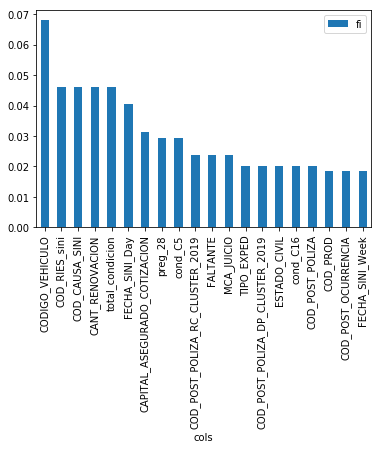

In [46]:
rf_fi = pd.DataFrame({'cols':X_train.columns, 'fi':best_model.best_estimator_.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [47]:
to_keep = list(rf_fi[rf_fi["fi"] >=0.005]["cols"].values)
print(f"# of features: {len(to_keep)} of {len(rf_fi)}")

# of features: 49 of 147


In [62]:
"""to_remove = ['COD_POST_POLIZA_RT_CLUSTER_2019', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019',
             'COD_POST_OCURRENCIA_RC_CLUSTER_2019',  'COD_POST_POLIZA_RC_CLUSTER_2019',
             'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'COD_POST_POLIZA_DP_CLUSTER_2019',
             "COD_CAUSA_SINI", 
            ] # "es_gte_5", "total_condicion", 

for col in to_remove:
    if(col in to_keep):
        to_keep.remove(col)
to_keep"""

'to_remove = [\'COD_POST_POLIZA_RT_CLUSTER_2019\', \'COD_POST_OCURRENCIA_RT_CLUSTER_2019\',\n             \'COD_POST_OCURRENCIA_RC_CLUSTER_2019\',  \'COD_POST_POLIZA_RC_CLUSTER_2019\',\n             \'COD_POST_OCURRENCIA_DP_CLUSTER_2019\', \'COD_POST_POLIZA_DP_CLUSTER_2019\',\n             "COD_CAUSA_SINI", \n            ] # "es_gte_5", "total_condicion", \n\nfor col in to_remove:\n    if(col in to_keep):\n        to_keep.remove(col)\nto_keep'

### Training again with less features

In [48]:
X_train_red = X_train[to_keep].copy()
print(len(X_train_red.columns))

49


In [49]:
# rf = RandomForestClassifier(n_estimators=40, max_features=0.5, min_samples_leaf=7, random_state=random_state, n_jobs=-1)
rf = copy(best_model.best_estimator_)
rf.fit(X_train_red, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.5, gamma=0, learning_rate=0.01,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              n_estimators=30, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=60, seed=0, silent=True,
              subsample=1)

In [50]:
y_opt_pred = rf.predict(X_opt[to_keep])
y_opt_f1_bestFI, y_opt_rocauc_bestFI = f1_score(y_opt, y_opt_pred), roc_auc_score(y_opt, y_opt_pred)
y_opt_f1_bestFI, y_opt_rocauc_bestFI

(0.45103857566765576, 0.7711014571454431)

In [51]:
confusion_matrix(y_opt, y_opt_pred)

array([[1106,  924],
       [   1,  380]])

**best model**<br>


In [52]:
pd.crosstab(X_opt["TIPO_EXPED"], [df_opt["EXISTE_FRAUDE"], y_opt_pred])

EXISTE_FRAUDE False       True       
col_1         False True  False True 
TIPO_EXPED                           
0                22     0     0     0
1               343     0     1     0
2               186     0     0     0
3               440     0     0     0
4                 6     0     0     0
5               103   293     0     9
6                 6   631     0   371

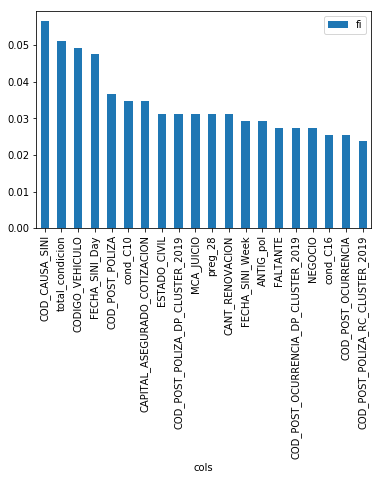

In [53]:
rf_fi = pd.DataFrame({'cols':X_train_red.columns, 'fi':rf.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [54]:
best_model = copy(rf)

In [ ]:
# best columns used
rf_fi["cols"].values

# model with validation set

## full features final model

In [77]:
rf_full = copy(best_model)
rf_full.fit(X_full_train, y_full_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 14},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=60, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=False, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [78]:
y_val_pred = rf_full.predict(X_val)
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, rf_full.predict_proba(X_val)[:, -1])
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.468, 0.905


In [79]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[4475,  388],
       [  69,  201]])

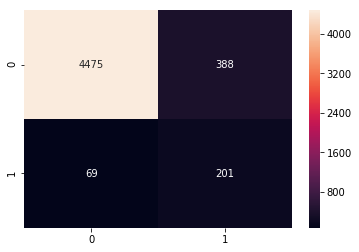

In [80]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## red features final model

In [55]:
rf_full = copy(best_model)
rf_full.fit(X_full_train[to_keep], y_full_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.5, gamma=0, learning_rate=0.01,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              n_estimators=30, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=60, seed=0, silent=True,
              subsample=1)

In [56]:
y_val_pred_prob = rf_full.predict_proba(X_val[to_keep])[:, -1]
y_val_pred = y_val_pred_prob > 0.5
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, y_val_pred_prob)
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.396, 0.824


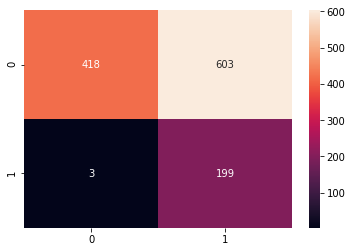

In [57]:
Y_val_adj = y_val_pred_prob > 0.5
conf_mat = confusion_matrix(y_val, Y_val_adj)
sns.heatmap(conf_mat, annot=True, fmt="d")

In [73]:
# 0.471, 0.832
# 580 441 4 198

In [74]:
pd.crosstab(X_val["TIPO_EXPED"], [y_val, Y_val_adj])

EXISTE_FRAUDE False       True       
col_1         False True  False True 
TIPO_EXPED                           
0                12     0     0     0
1               159     0     0     0
2               101     0     0     0
3                86     0     0     0
4                 2     0     0     0
5               272     2     6     0
6               258   129    96   100

## Tronador (sum cond >=5) comparison

In [86]:
# comparing against > 5 logic
y_tronador = X_val["total_condicion"] >= 5
print(f"({f1_score(y_val, y_tronador)},{roc_auc_score(y_val, y_tronador)})")

(0.3834296724470134,0.6806251878860756)


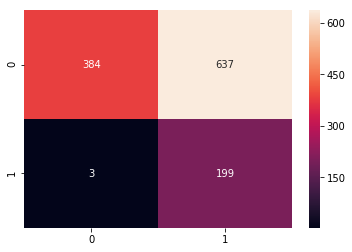

In [87]:
conf_mat = confusion_matrix(y_val, y_tronador)
sns.heatmap(conf_mat, annot=True, fmt="d")

In [88]:
pd.crosstab(X_val["TIPO_EXPED"], [y_val, y_tronador])

EXISTE_FRAUDE   False       True       
total_condicion False True  False True 
TIPO_EXPED                             
0                   9     3     0     0
1                 123    36     0     0
2                  95     6     0     0
3                  86     0     0     0
4                   2     0     0     0
5                  42   232     1     5
6                  27   360     2   194

In [64]:
# use for test without dump  it into disk
m = copy(rf_full)
columns = copy(to_keep)

# Saving final model & columns used into hard drive

In [65]:
path_to_save = f"models/{model_id}/"
os.makedirs(path_to_save, exist_ok=True)

In [66]:
model_file = os.path.join(path_to_save, f"{model_id}.pickle")

with open(model_file, "wb") as f:
    pickle.dump(best_model, f, pickle.HIGHEST_PROTOCOL)

In [67]:
# save file for humans
model_file = os.path.join(path_to_save, f"{model_id} - readable.pickle")

with open(model_file, "wb") as f:
    pickle.dump(best_model, f, 0) # 0 is human readable format

In [68]:
# merging list input & target
full_cols = list(to_keep)  # + ["EXISTE_FRAUDE"]
print(full_cols)

['CODIGO_VEHICULO', 'COD_RIES_sini', 'COD_CAUSA_SINI', 'CANT_RENOVACION', 'total_condicion', 'FECHA_SINI_Day', 'CAPITAL_ASEGURADO_COTIZACION', 'preg_28', 'cond_C5', 'COD_POST_POLIZA_RC_CLUSTER_2019', 'FALTANTE', 'MCA_JUICIO', 'TIPO_EXPED', 'COD_POST_POLIZA_DP_CLUSTER_2019', 'ESTADO_CIVIL', 'cond_C16', 'COD_POST_POLIZA', 'COD_PROD', 'COD_POST_OCURRENCIA', 'FECHA_SINI_Week', 'FECHA_SINI_Month', 'MCA_COASEG', 'NEGOCIO', 'PRENDARIO', 'SEGMENTO', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019', 'preg_27', 'CONV_COMISIONARIO', 'ANTIG_pol', 'cond_C10', 'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'existe_FECHA_FORMAL', 'cond_C11', 'CODIGO_CARATULA', 'TIPO_SINIESTRO', 'cond_C2', 'cond_C15', 'DOMICILIO_CODIGO_POSTAL', 'dist_fformal_fsini', 'ESTADO_CIVIL_TERC', 'CIF_ID', 'COD_POST_OCURRENCIA_RC_CLUSTER_2019', 'CONDICION_ROBO_EXP50', 'FECHA_SINI_Dayofweek', 'DESCRIPCION_TIPO', 'SEXO', 'preg_9', 'CAPITAL_VEHICULO', 'cond_C6']


In [69]:
columns_file = os.path.join(path_to_save, f"{model_id} (COLUMNS) - n_features_{len(full_cols)}.pickle")

with open(columns_file, "wb") as file:
    pickle.dump(full_cols, file, pickle.HIGHEST_PROTOCOL)

In [120]:
# saving to use as example a few rows to implement the model
# path_to_save = "../../src/data/1.1 - df_train 01-18to12-18/"
# sample_file = os.path.join(path_to_save, f"{model_id} (sample)  - dataset example to predict model.csv")

# df_example = X_val.loc[:, to_keep][-50:]
# df_example["EXISTE_FRAUDE"] = y_val[-50:]
# df_example.to_csv(sample_file)

In [ ]:
# df_example.head()

# Test prediction

In [80]:
df_test = pd.read_feather(os.path.join(path, "1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather"))

In [81]:
df_test.shape

(34658, 157)

In [71]:
df_test = df_test[(df_test["total_condicion"] >= 4)]

In [72]:
# Loding the model

def load_model(model_file):
    """Load the dump model."""
    with open(model_file, "rb") as file:
        m = pickle.load(file)
    return m


def load_columns(columns_file):
    """Load the array of columns use in the dump model."""
    with open(columns_file, "rb") as file:
        columns = pickle.load(file)
    return columns

In [73]:
m = load_model(model_file)
columns = load_columns(columns_file)

In [74]:
print(columns)

['CODIGO_VEHICULO', 'COD_RIES_sini', 'COD_CAUSA_SINI', 'CANT_RENOVACION', 'total_condicion', 'FECHA_SINI_Day', 'CAPITAL_ASEGURADO_COTIZACION', 'preg_28', 'cond_C5', 'COD_POST_POLIZA_RC_CLUSTER_2019', 'FALTANTE', 'MCA_JUICIO', 'TIPO_EXPED', 'COD_POST_POLIZA_DP_CLUSTER_2019', 'ESTADO_CIVIL', 'cond_C16', 'COD_POST_POLIZA', 'COD_PROD', 'COD_POST_OCURRENCIA', 'FECHA_SINI_Week', 'FECHA_SINI_Month', 'MCA_COASEG', 'NEGOCIO', 'PRENDARIO', 'SEGMENTO', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019', 'preg_27', 'CONV_COMISIONARIO', 'ANTIG_pol', 'cond_C10', 'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'existe_FECHA_FORMAL', 'cond_C11', 'CODIGO_CARATULA', 'TIPO_SINIESTRO', 'cond_C2', 'cond_C15', 'DOMICILIO_CODIGO_POSTAL', 'dist_fformal_fsini', 'ESTADO_CIVIL_TERC', 'CIF_ID', 'COD_POST_OCURRENCIA_RC_CLUSTER_2019', 'CONDICION_ROBO_EXP50', 'FECHA_SINI_Dayofweek', 'DESCRIPCION_TIPO', 'SEXO', 'preg_9', 'CAPITAL_VEHICULO', 'cond_C6']


In [75]:
# create cant_cond column
cond_cols = df.filter(regex="^cond_").columns
df_test["cant_cond"] = (df_test[cond_cols] > 0).sum(axis=1)
df_test["cant_cond"].value_counts(dropna=False)

2    389
1     56
3     41
4      3
Name: cant_cond, dtype: int64

In [76]:
X_test = df_test[columns]
y_test = df_test["EXISTE_FRAUDE"]

## Model in test

In [77]:
# using trained model
y_test_pred_prob = m.predict_proba(X_test)[:, -1]

# Using load model
# y_test_pred_prob = m.predict_proba(X_test)[:, -1]

print("%.3f, %.3f" % (f1_score(y_test, y_test_pred_prob > 0.5), roc_auc_score(y_test, y_test_pred_prob)))

0.367, 0.850


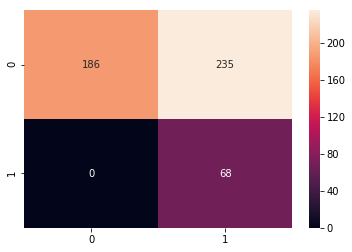

In [78]:
y_prob_adj = y_test_pred_prob > 0.5
conf_mat = confusion_matrix(y_test, y_prob_adj)
sns.heatmap(conf_mat, annot=True, fmt="d")

In [79]:
pd.crosstab(df_test["TIPO_EXPED"], [df_test["EXISTE_FRAUDE"], y_prob_adj])

EXISTE_FRAUDE False       True 
col_1         False True  True 
TIPO_EXPED                     
0                 5     0     0
1                65     0     0
2                41     0     0
3                34     0     0
5                35    88     5
6                 6   147    63

## Tronador in test

In [71]:
y_tronador = df_test["es_gte_5"]
print("%.3f, %.3f" % (f1_score(y_test, y_tronador), roc_auc_score(y_test, y_tronador)))

0.354, 0.705


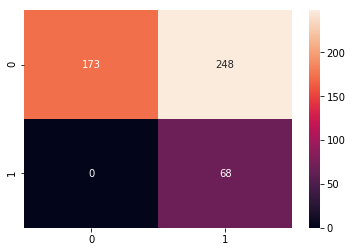

In [72]:
conf_mat = confusion_matrix(y_test, y_tronador)
sns.heatmap(conf_mat, annot=True, fmt="d")

In [78]:
pd.crosstab(df_test["TIPO_EXPED"], [df_test["EXISTE_FRAUDE"], y_tronador])

EXISTE_FRAUDE False       True 
es_gte_5      False True  True 
TIPO_EXPED                     
0                 3     2     0
1                54    11     0
2                40     1     0
3                33     1     0
5                26    97     5
6                17   136    63